In [1]:
!pip install tf-nightly-2.0-preview

     |████████████████████████████████| 79.2MB 370kB/s 
     |████████████████████████████████| 3.2MB 33.5MB/s 
     |████████████████████████████████| 450kB 47.0MB/s 


reference: https://medium.com/@Inoryy/deep-reinforcement-learning-with-tensorflow-2-0-d8e62102680d

In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.executing_eagerly())

2.0.0-dev20190623
True


In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
print(tf.reduce_sum([1, 2, 3, 4, 5]))

tf.Tensor(15, shape=(), dtype=int32)


In [0]:
import numpy as np
import logging
import tensorflow as tf
import tensorflow.keras.layers as kl

class ProbabilityDistribution(tf.keras.Model):
  def call(self, logits):
    # return a sample categorical action from given logits
    return tf.squeeze(tf.random.categorical(logits, 1), axis=-1)
  
class Model(tf.keras.Model):
  def __init__(self, num_actions):
    super().__init__('mlp_policy')
    # no tf.variable() just simple keras api
    self.hidden1 = kl.Dense(128, activation='relu')
    self.hidden2 = kl.Dense(128, activation='relu')
    self.value = kl.Dense(1, name='value')
    # logits are unnormalised log probabilities
    self.logits = kl.Dense(num_actions, name='policy_logits')
    self.dist = ProbabilityDistribution()
    
  def call(self, inputs):
    # inputs is a numpy array convert to tensor
    x = tf.convert_to_tensor(inputs, dtype=tf.float32)
    # separate input tensor for the same input tensor
    hidden_logs = self.hidden1(x)
    hidden_vals = self.hidden2(x)
    return self.logits(hidden_logs), self.value(hidden_vals)
  
  def action_value(self, obs):
    # executes call under the hood
    logits, value = self.predict(obs)
    action = self.dist.predict(logits)
    # simpler option will be clear below why we dont use it
    # action = tf.random.categorical(logits, 1)
    return np.squeeze(action, axis=-1), np.squeeze(value, axis=-1)

In [7]:
import gym

env = gym.make('CartPole-v0')

model = Model(num_actions=env.action_space.n)

obs = env.reset()
# no feed_dict or tf.Session() needed at all
action, value = model.action_value(obs[None, :])

print(action, value)

0 [0.00716775]


In [0]:
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko

class A2CAgent:
  def __init__(self, model):
    # hyperparameters for loss terms
    self.params = {'value': 0.5, 'entropy': 0.0001, 'gamma': 0.99}
    self.model = model
    self.model.compile(
        optimizer = ko.RMSprop(lr=0.0007),
        # define separte losses for policy logits and value estimate
        loss = [self._logits_loss, self._value_loss]
    )
    
  def train(self, env, batch_sz=32, updates=1000):
    # storage helpers for a single batch of data
    actions = np.empty((batch_sz,), dtype=np.int32)
    rewards, dones, values = np.empty((3, batch_sz))
    observations = np.empty((batch_sz,) + env.observation_space.shape)
    # training loop: collect samples, sent to optimizer, train
    ep_rews = [0.0]
    next_obs = env.reset()
    for update in range(updates):
      for step in range(batch_sz):
        observations[step] = next_obs.copy()
        actions[step], values[step] = self.model.action_value(next_obs[None, :])
        next_obs, rewards[step], dones[step], _ = env.step(actions[step])
        ep_rews[-1] += rewards[step]
        if dones[step]:
          ep_rews.append(0.0)
          next_obs = env.reset()
          logging.info("Episode: %03d, Rewards: %03d" % (len(ep_rews)-1, ep_rews[-2]))
          
      _, next_value = self.model.action_value(next_obs[None, :])
      returns, advs = self._returns_advantages(rewards, dones, values, next_value)
      # a trick to input actions and advantages through same API
      acts_and_advs = np.concatenate([actions[:, None], advs[:, None]], axis=-1)
      # performs a full training step on the collected batch
      # note: no need to mess around with gradients, Keras API handles it.
      losses = self.model.train_on_batch(observations, [acts_and_advs, returns])
      logging.debug("[%d/%d] Losses %s" % (update+1, updates, losses))
    return ep_rews
    
  def test(self, env, render=False):
    obs, done, ep_reward = env.reset(), False, 0

    while not done:
      action, _ = self.model.action_value(obs[None, :])
      obs, reward, done, _ = env.step(action)
      ep_reward += reward
      if render:
        env.render()

    return ep_reward
  
  def _returns_advantages(self, rewards, dones, values, next_value):
    # next values is the bootstrap value estimate of a future state (the critic)
    returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
    # returns are calculated are discounted sum of future rewards
    for t in reversed(range(rewards.shape[0])):
      returns[t] = rewards[t] + self.params['gamma'] * returns[t+1] * (1-dones[t])
    returns = returns[:-1]
    # advantages are returns - baseline, value estimates in our own
    advantages = returns - value
    return returns, advantages
  
  def _value_loss(self, returns, value):
    # value loss is typically MSE between value est and returns
    loss = kls.mean_squared_error(returns, value)
    return self.params['value'] * loss
  
  def _logits_loss(self, acts_and_advs, logits):
    # a trick to inputs and advantages through some API
    actions, advs = tf.split(acts_and_advs, 2, axis=-1)
    # sparse categorical CE loss obj, supports sample weights arg
    # from_logits arg ensures normalized probabilities
    weight_space = kls.SparseCategoricalCrossentropy(from_logits=True)
    # policy loss: policy gradients, weighted by advantages
    # note: we only calculate the loss on the actionswe have taken
    actions = tf.cast(actions, tf.int32)
    policy_loss = weight_space(actions, logits, sample_weight=advs)
    # entropy loss can be calculated via CE over itself
    entropy_loss = kls.categorical_crossentropy(logits, logits, from_logits=True)
    # here signs are flipped because optimizer minimizes
    return policy_loss - self.params['entropy'] * entropy_loss

In [38]:
agent = A2CAgent(model)
rewards_sum = agent.test(env)
print("%d out of 200" % rewards_sum)

17 out of 200


In [46]:
# set to logging.WARNING to disable logs or logging.DEBUG to see losses as well
logging.getLogger().setLevel(logging.INFO)

agent = A2CAgent(model)
rewards_history = agent.train(env)
print("Finished training, testing ...")
print("%d out of 200" % agent.test(env))

I0623 15:08:44.590524 139948063606656 <ipython-input-44-6c72245ce322>:32] Episode: 001, Rewards: 101
I0623 15:08:45.085615 139948063606656 <ipython-input-44-6c72245ce322>:32] Episode: 002, Rewards: 196
I0623 15:08:45.503775 139948063606656 <ipython-input-44-6c72245ce322>:32] Episode: 003, Rewards: 155
I0623 15:08:46.015667 139948063606656 <ipython-input-44-6c72245ce322>:32] Episode: 004, Rewards: 200
I0623 15:08:46.337603 139948063606656 <ipython-input-44-6c72245ce322>:32] Episode: 005, Rewards: 119
I0623 15:08:46.751806 139948063606656 <ipython-input-44-6c72245ce322>:32] Episode: 006, Rewards: 156
I0623 15:08:47.072153 139948063606656 <ipython-input-44-6c72245ce322>:32] Episode: 007, Rewards: 120
I0623 15:08:47.329771 139948063606656 <ipython-input-44-6c72245ce322>:32] Episode: 008, Rewards: 097
I0623 15:08:47.808275 139948063606656 <ipython-input-44-6c72245ce322>:32] Episode: 009, Rewards: 184
I0623 15:08:48.073734 139948063606656 <ipython-input-44-6c72245ce322>:32] Episode: 010, Rew

Finished training, testing ...
120 out of 200


In [47]:
print("Total Episode Reward: %d out of 200" % agent.test(env))

Total Episode Reward: 200 out of 200


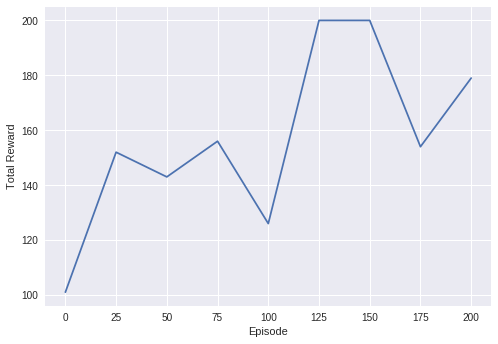

In [48]:
plt.style.use('seaborn')
plt.plot(np.arange(0, len(rewards_history), 25), rewards_history[::25])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()